In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision import models

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
print(torch.__version__)

1.5.1


In [17]:
def train_model(model, criterion, optimizer, scheduler, metric, num_epochs=25):
    since = time.time()
    
    epoch_loss_train = []
    epoch_acc_train = []
    
    epoch_loss_test = []
    epoch_acc_test = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', metric]:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                epoch_loss_train.append(running_loss / dataset_sizes[phase])
                epoch_acc_train.append(running_corrects.double() / dataset_sizes[phase])
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss_train[-1], epoch_acc_train[-1]))
            else:
                epoch_loss_test.append(running_loss / dataset_sizes[phase])
                epoch_acc_test.append(running_corrects.double() / dataset_sizes[phase])
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss_test[-1], epoch_acc_test[-1]))
            
            # deep copy the model
            if phase == metric and epoch_acc_test[-1] > best_acc:
                best_acc = epoch_acc_test[-1]
                best_model_wts = copy.deepcopy(model.state_dict())

            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best '+ str(metric) +' accuracy: {:4f}\n'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (epoch_loss_train, epoch_acc_train), (epoch_loss_test, epoch_acc_test), best_acc

In [18]:
def loss_acc_plot(acc_loss, who, loss=True):
    acc = []
    for i in range(len(acc_loss[1])):
        acc.append(acc_loss[1][i].cpu().item())
    if loss:    
        plt.plot(range(len(acc_loss[0])), acc_loss[0], label='loss')
    plt.plot(range(len(acc_loss[1])), acc, label='accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')
    plt.title(str(who) +': loss and accuracy plot')
    plt.show()

In [19]:
def compare_models(models):
    for m in models:
        acc = []
        for i in range(len(m[2][1])):
            acc.append(m[2][1][i].cpu().item())
        plt.plot(range(len(m[2][1])), acc, label=str(m[0].__class__.__name__))
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')
    plt.title('Test accuracy')
    plt.show()

## Learning rate and momentum tuning (IS NOT NECESSARY TO RUN THE CELL BELOW)

In [47]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'traffic'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

learning_rate = [0.001, 0.005, 0.1]
momentum = [0.3, 0.5, 0.7, 0.9]

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)

model = model.to(device)
criterion = nn.CrossEntropyLoss()

accs = []

for i in range(2):
    print('Using lr: ' + str(learning_rate[0]) + ' and m: ' + str(momentum[i]))
    if i == 0:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate[0], momentum=momentum[i])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        model = train_model(model, criterion, optimizer, exp_lr_scheduler, metric='val', num_epochs=10)
        accs.append((model[3], learning_rate[0], momentum[i]))
    else:
        optimizer = optim.SGD(model[0].parameters(), lr=learning_rate[0],momentum=momentum[i])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        model = train_model(model[0], criterion, optimizer, exp_lr_scheduler, metric='val', num_epochs=10)
        accs.append((model[3], learning_rate[0], momentum[i]))

for i in range(1, len(learning_rate)):
    for m in range(len(momentum)):
        print('Using lr: ' + str(learning_rate[i]) + ' and m: ' + str(momentum[m]))
        optimizer = optim.SGD(model[0].parameters(), lr=learning_rate[i],momentum=momentum[m])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        model = train_model(model[0], criterion, optimizer, exp_lr_scheduler, metric='val', num_epochs=10)
        accs.append((model[3], learning_rate[i], momentum[m]))

best_params = []
for i in range(len(accs)):
    best_params.append(accs[i][0].cpu().item())
# best val
learning_rate = accs[np.argmax(best_params)][1] # 1 is for learning rate
momentum = accs[np.argmax(best_params)][2] # 2 is for momentum

Using lr= 0.001 and m= 0.5
Epoch 0/0
----------
train Loss: 1.3738 Acc: 0.6115
val Loss: 0.2404 Acc: 0.9467
Training complete in 0m 50s
Best val accuracy: 0.946746

Using lr= 0.001 and m= 0.7
Epoch 0/0
----------
train Loss: 0.6008 Acc: 0.8461
val Loss: 0.0562 Acc: 0.9882
Training complete in 0m 51s
Best val accuracy: 0.988166

Using lr= 0.005 and m= 0
Epoch 0/0
----------
train Loss: 0.4625 Acc: 0.8700
val Loss: 0.0373 Acc: 0.9921
Training complete in 0m 51s
Best val accuracy: 0.992110

Using lr= 0.005 and m= 1
Epoch 0/0
----------
train Loss: 0.4124 Acc: 0.8821
val Loss: 0.0350 Acc: 0.9875
Training complete in 0m 51s
Best val accuracy: 0.987508



[(tensor(0.9467, device='cuda:0', dtype=torch.float64), 0.001, 0.5),
 (tensor(0.9882, device='cuda:0', dtype=torch.float64), 0.001, 0.7),
 (tensor(0.9921, device='cuda:0', dtype=torch.float64), 0.005, 0.5),
 (tensor(0.9875, device='cuda:0', dtype=torch.float64), 0.005, 0.7)]

## Tuning step size and gamma (IS NOT NECESSARY TO RUN THE CELL BELOW)

In [ ]:
step_size = [1, 5, 7, 10]
gamma = [0.1, 0.5, 1]

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)

model = model.to(device)
criterion = nn.CrossEntropyLoss()

accs = []

for i in range(2):
    print('Using step_size: ' + str(step_size[0]) + ' and gamma: ' + str(gamma[i]))
    if i == 0:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size[0], gamma=gamma[i])
        model = train_model(model, criterion, optimizer, exp_lr_scheduler, metric='val', num_epochs=10)
        accs.append((model[3], step_size[0], gamma[i]))
    else:
        optimizer = optim.SGD(model[0].parameters(), lr=learning_rate, momentum=momentum)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size[0], gamma=gamma[i])
        model = train_model(model[0], criterion, optimizer, exp_lr_scheduler, metric='val', num_epochs=10)
        accs.append((model[3], step_size[0], gamma[i]))

for i in range(1, len(step_size)):
    for g in range(len(gamma)):
        print('Using step_size: ' + str(step_size[i]) + ' and gamma: ' + str(gamma[g]))
        optimizer = optim.SGD(model[0].parameters(), lr=learning_rate ,momentum=momentum)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size[i], gamma=gamma[g])
        model = train_model(model[0], criterion, optimizer, exp_lr_scheduler, metric='val', num_epochs=10)
        accs.append((model[3], step_size[i], gamma[g]))
        
best_params = []
for i in range(len(accs)):
    best_params.append(accs[i][0].cpu().item())
# best val
step_size = accs[np.argmax(best_params)][1] # 1 is for step_size
gamma = accs[np.argmax(best_params)][2] # 2 is for gamma

# Train and test

In [20]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'traffic'
output_feature = 21
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [21]:
# best hyperparameters values found
learning_rate = 0.005
momentum = 0.5
step_size = 10
gamma = 0.5

## ResNet18

In [23]:
model = torchvision.models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, output_feature)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, metric='test', num_epochs=2)

Epoch 0/1
----------
train Loss: 0.8505 Acc: 0.7551
test Loss: 0.2463 Acc: 0.9448
Epoch 1/1
----------
train Loss: 0.3674 Acc: 0.8986
test Loss: 0.1984 Acc: 0.9655
Training complete in 1m 38s
Best test accuracy: 0.965493



### Accuracy and loss on training 

In [4]:
loss_acc_plot(model[1], who='training') # model[1] is for training

NameError: name 'loss_acc_plot' is not defined

### Accuracy and loss on testing

In [103]:
loss_acc_plot(model[2], who='testing') # model[2] is for testing

# AlexNet

In [104]:
model2 = torchvision.models.alexnet(pretrained=True)
model2.classifier[-1] = nn.Linear(in_features=4096, out_features=output_feature)

model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate, momentum=momentum)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model2 = train_model(model2, criterion, optimizer, exp_lr_scheduler, metric='test', num_epochs=2)

Epoch 0/1
----------
train Loss: 1.2357 Acc: 0.6339
test Loss: 0.8430 Acc: 0.7819
Epoch 1/1
----------
train Loss: 0.6325 Acc: 0.8123
test Loss: 0.6037 Acc: 0.8496
Training complete in 1m 18s
Best test accuracy: 0.849551



### Accuracy and loss on training

In [ ]:
loss_acc_plot(model2[1], who='training')

### Accuracy and loss on testing

In [ ]:
loss_acc_plot(model2[2], who='testing')

## VGG16

In [26]:
model3 = torchvision.models.vgg16(pretrained=True)
model3.classifier[-1] = nn.Linear(in_features=4096, out_features=output_feature)

model3 = model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=learning_rate, momentum=momentum)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model3 = train_model(model3, criterion, optimizer, exp_lr_scheduler, metric='test', num_epochs=2)

Epoch 0/1
----------
train Loss: 1.0214 Acc: 0.7071
test Loss: 0.5264 Acc: 0.8523
Epoch 1/1
----------
train Loss: 0.5147 Acc: 0.8480
test Loss: 0.2615 Acc: 0.9510
Training complete in 5m 20s
Best test accuracy: 0.951001



### Accuracy and loss on training

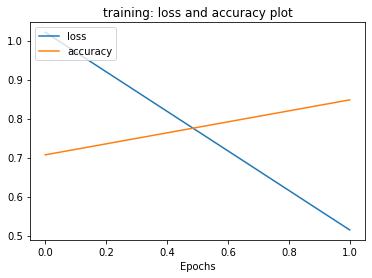

In [29]:
loss_acc_plot(model3[1], who='training')

### Accuracy and loss on testing

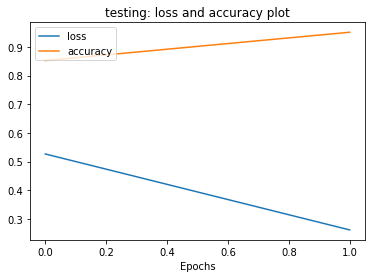

In [30]:
loss_acc_plot(model3[2], who='testing')

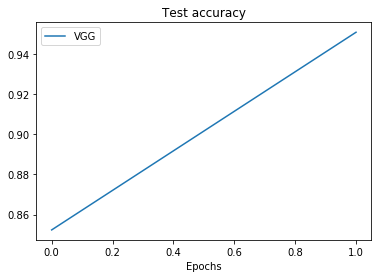

In [28]:
compare_models([model, model2, model3])

# Documentation

# PART I

**IMPORTANT NOTES**: for a correct execution of the program you should have pytorch installed with version 1.4.0 along all its libraries I am using in the code.

The cells where on the heading is written "IS NOT NECESSARY TO RUN THE CELL BELOW" means that the underneath cell is not necessary to be ran because it does the tuning of some parameters whose best values have already been found (because I ran that code on my computer).

**Data preparation**: the given data was structured in train and test set. Moreover these data was splitted in two folders (Belgium and Germany). I decided to merge the data of these two folders both for the training and test set. Moreover, to do hyperparameter tuning, I splitted the training set into two sets: training and validation set.
So now the data has this structure:

    traffic/
        - train/ (training set)
        - val/ (validation set)
        - test/ (test set)


The function that trains the model is the functon `train_model`. At the beginning my first attempt has been to use *Transfer Learning* using a pretrained ImageNet model and apply fine tuning on it. However, at test time, this turns out to be not efficient at all since the accuracy of the model peaked at roughly 80%. <br>
Therefore I decided to still keep the model's structure of the ImageNet models I tried before, but without fine tuning them. So updating all the model's parameters again when training it with my data (of course I had to change the output layer of the network to my specific case). This boosted the accuracy of the model to ~90%. <br>

In order to still raise the accuracy, I applied *data augmentation* and *hyperparameter tunig*. For data augmentation has been important to look first at the images of the road signs  since some operations like vertical flipping should have not been applied since this could have causes a road sign to look similar to another sign after such transformation.
The tuned hyperparameters alongside their values are the following:

```python
    # best hyperparameters values found
    learning_rate = 0.005
    momentum = 0.5
    step_size = 10
    gamma = 0.5
```
These are used in the optimization function Stochastic Gradient Descent(SGD) and Step Learning Rate(StepLR).

Done that, I tested three different model architecture of ImageNet, in particular **ResNet18**, **AlexNet** and **DenseNet161**. The best performance has been reached by ResNet18 (as it can be seen from the chart that the function `compare_models` outputs -- note that you have to train the three models and then run the last cell `compare_models([model, model2, model3])` to see the chart) reaching ~98-99% of accuracy on the test set after 25 epochs and a batch size of 4.

### Deployment of the model on edge device

In order to build a model that is suitable for deployment on edge devices the first thing that comes to my mind was to choose a network architecture that is much lighter (in terms of number of layers) than the architectures I used here. Since this is a custom problem, one could think of building a custom CNN specific for this problem and then test its performace, and actually this can be easily done. The main problem, however, concerns with the edge device characteristics. Is is very likely that the resources like RAM, CPU, GPU and power are very limited, therefore I would look for frameworks that have been specifically designed for this like Tensorflow Lite or similar.

# PART II

To deal with this part, I trained a model based on just the data labeled with 12 and 13 to see how difficult was to classify them (namely left and right curve) using the same process as before (namely creating a validation set and finding the best hyperparameters for the model). Here an important thing to notice is that, when I do data augmentation, I should not apply the horizontal nor vertical flipping of the data. In fact, doing so, the performance drops dramatically.

NOTE: To train the model based on just these two labels, it is sufficient to change the line of code `data_dir = 'traffic'` under the heading "Train and test" to `data_dir = 'left_right'` and then change the line immediately below `output_feature = 21` to `output_feature=2` and run everything again.

The trained model peaked a very high accuracy on the test set, sometimes also 100% and an accuracy of ~90% on the training set. This makes me think a little bit. At the beginning I thought this was realted to an underfitting but therefore I decided to look at the data I was training and testing on and I noticed that the test data where few (a dozens) and they were much cleaner than the training data. So I concluded that the model has been trained enough to correctly classify the images on the test set. Contrarily, some images in the training set were blurry and skewed so it is normal for the training set having a lower accuracy since it is much difficult for the model to correctly classify that type of road signs.
However, I am aware that a 100% of accuracy on the test set is quite unrealistic, this is probably due to the not-so-good split of the data.

Having done these experiments on just these two labels I decided to not doing further modification to my orginal model since on these two labels I had 100% of accuracy on the test set. Of course I paid attention to not apply wrong data augmentation transformations.